# Collaborative filtering on Google Analytics data

This notebook demonstrates how to implement a WALS matrix refactorization approach to do collaborative filtering.

In [1]:
import os
PROJECT = 'qwiklabs-gcp-ef77b6ec6923f37d' # REPLACE WITH YOUR PROJECT ID
BUCKET = 'qwiklabs-gcp-ef77b6ec6923f37d' # REPLACE WITH YOUR BUCKET NAME
REGION = 'us-east1' # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

# do not change these
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['TFVERSION'] = '1.8'

In [2]:
%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


In [3]:
import tensorflow as tf
print(tf.__version__)

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.8.0


## Create raw dataset
<p>
For collaborative filtering, we don't need to know anything about either the users or the content. Essentially, all we need to know is userId, itemId, and rating that the particular user gave the particular item.
<p>
In this case, we are working with newspaper articles. The company doesn't ask their users to rate the articles. However, we can use the time-spent on the page as a proxy for rating.
<p>
Normally, we would also add a time filter to this ("latest 7 days"), but our dataset is itself limited to a few days.

In [4]:
import google.datalab.bigquery as bq

sql="""
#standardSQL
WITH visitor_page_content AS (

   SELECT  
     fullVisitorID,
     (SELECT MAX(IF(index=10, value, NULL)) FROM UNNEST(hits.customDimensions)) AS latestContentId,  
     (LEAD(hits.time, 1) OVER (PARTITION BY fullVisitorId ORDER BY hits.time ASC) - hits.time) AS session_duration 
   FROM `cloud-training-demos.GA360_test.ga_sessions_sample`,   
     UNNEST(hits) AS hits
   WHERE 
     # only include hits on pages
      hits.type = "PAGE"

   GROUP BY   
     fullVisitorId, latestContentId, hits.time
     )

# aggregate web stats
SELECT   
  fullVisitorID as visitorId,
  latestContentId as contentId,
  SUM(session_duration) AS session_duration 
 
FROM visitor_page_content
  WHERE latestContentId IS NOT NULL 
  GROUP BY fullVisitorID, latestContentId
  HAVING session_duration > 0
  ORDER BY latestContentId 
"""

df = bq.Query(sql).execute().result().to_dataframe()
df.head()

,visitorId,contentId,session_duration
0,7337153711992174438,100074831,44652
1,5190801220865459604,100170790,1214205
2,5874973374932455844,100510126,32109
3,2293633612703952721,100510126,47744
4,1173698801255170595,100676857,10512


In [5]:
stats = df.describe()
stats

,session_duration
count,2.789130e+05
mean,1.272188e+05
std,2.346439e+05
min,1.000000e+00
25%,1.709500e+04
50%,5.793800e+04
75%,1.293930e+05
max,7.690598e+06


/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


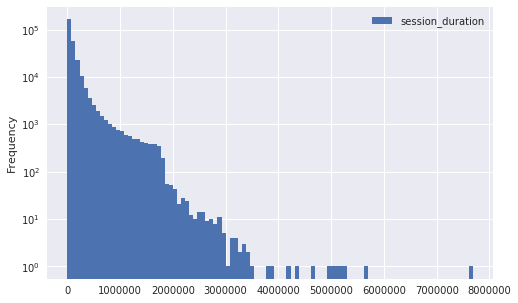

In [6]:
df[['session_duration']].plot(kind='hist', logy=True, bins=100, figsize=[8,5])

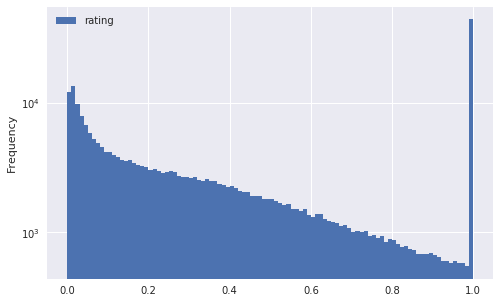

In [7]:
# the rating is the session_duration scaled to be in the range 0-1.  This will help with training.
median = stats.loc['50%', 'session_duration']
df['rating'] = 0.3 * df['session_duration'] / median
df.loc[df['rating'] > 1, 'rating'] = 1
df[['rating']].plot(kind='hist', logy=True, bins=100, figsize=[8,5])

In [8]:
del df['session_duration']

In [9]:
%bash
rm -rf data
mkdir data

In [10]:
df.to_csv('data/collab_raw.csv', index=False, header=False)

In [11]:
!head data/collab_raw.csv

7337153711992174438,100074831,0.23120577168697573
5190801220865459604,100170790,1.0
5874973374932455844,100510126,0.16625875936345746
2293633612703952721,100510126,0.24721598950602366
1173698801255170595,100676857,0.054430598225689526
7262596434087807556,100735153,0.23134039835686424
883397426232997550,10083328,0.9450274431288619
1808867070685560283,100906145,1.0
7615995624631762562,100906145,0.48231040077324033
5519169380728479914,100915139,0.199485657081708


## Create dataset for WALS
<p>
The raw dataset (above) won't work for WALS:
<ol>
<li> The userId and itemId have to be 0,1,2 ... so we need to create a mapping from visitorId (in the raw data) to userId and contentId (in the raw data) to itemId.
<li> We will need to save the above mapping to a file because at prediction time, we'll need to know how to map the contentId in the table above to the itemId.
<li> We'll need two files: a "rows" dataset where all the items for a particular user are listed; and a "columns" dataset where all the users for a particular item are listed.
</ol>

<p>

### Mapping

In [12]:
import pandas as pd
import numpy as np
def create_mapping(values, filename):
  with open(filename, 'w') as ofp:
    value_to_id = {value:idx for idx, value in enumerate(values.unique())}
    for value, idx in value_to_id.items():
      ofp.write('{},{}\n'.format(value, idx))
  return value_to_id

df = pd.read_csv('data/collab_raw.csv',
                 header=None,
                 names=['visitorId', 'contentId', 'rating'],
                dtype={'visitorId': str, 'contentId': str, 'rating': np.float})
df.to_csv('data/collab_raw.csv', index=False, header=False)
user_mapping = create_mapping(df['visitorId'], 'data/users.csv')
item_mapping = create_mapping(df['contentId'], 'data/items.csv')

In [13]:
!head -3 data/*.csv

==> data/collab_raw.csv <==
7337153711992174438,100074831,0.2312057716869757
5190801220865459604,100170790,1.0
5874973374932455844,100510126,0.16625875936345744

==> data/items.csv <==
236941062,1402
299786600,4672
243874813,1540

==> data/users.csv <==
1672553935406836733,2849
3588200922529727879,41146
7789950935531938708,60125


In [14]:
df['userId'] = df['visitorId'].map(user_mapping.get)
df['itemId'] = df['contentId'].map(item_mapping.get)

In [15]:
mapped_df = df[['userId', 'itemId', 'rating']]
mapped_df.to_csv('data/collab_mapped.csv', index=False, header=False)
mapped_df.head()

,userId,itemId,rating
0,0,0,0.231206
1,1,1,1.000000
2,2,2,0.166259
3,3,2,0.247216
4,4,3,0.054431


### Creating rows and columns datasets

In [16]:
import pandas as pd
import numpy as np
mapped_df = pd.read_csv('data/collab_mapped.csv', header=None, names=['userId', 'itemId', 'rating'])
mapped_df.head()

,userId,itemId,rating
0,0,0,0.231206
1,1,1,1.000000
2,2,2,0.166259
3,3,2,0.247216
4,4,3,0.054431


In [17]:
NITEMS = np.max(mapped_df['itemId']) + 1
NUSERS = np.max(mapped_df['userId']) + 1
mapped_df['rating'] = np.round(mapped_df['rating'].values, 2)
print '{} items, {} users, {} interactions'.format( NITEMS, NUSERS, len(mapped_df) )

5668 items, 82802 users, 278913 interactions


In [18]:
grouped_by_items = mapped_df.groupby('itemId')
iter = 0
for item, grouped in grouped_by_items:
  print item, grouped['userId'].values, grouped['rating'].values
  iter = iter + 1
  if iter > 5:
    break

0 [0] [0.23]
1 [1] [1.]
2 [2 3] [0.17 0.25]
3 [4] [0.05]
4 [5] [0.23]
5 [6] [0.95]


In [19]:
import tensorflow as tf
grouped_by_items = mapped_df.groupby('itemId')
with tf.python_io.TFRecordWriter('data/users_for_item') as ofp:
  for item, grouped in grouped_by_items:
    example = tf.train.Example(features=tf.train.Features(feature={
          'key': tf.train.Feature(int64_list=tf.train.Int64List(value=[item])),
          'indices': tf.train.Feature(int64_list=tf.train.Int64List(value=grouped['userId'].values)),
          'values': tf.train.Feature(float_list=tf.train.FloatList(value=grouped['rating'].values))
        }))
    ofp.write(example.SerializeToString())      

In [20]:
grouped_by_users = mapped_df.groupby('userId')
with tf.python_io.TFRecordWriter('data/items_for_user') as ofp:
  for user, grouped in grouped_by_users:
    example = tf.train.Example(features=tf.train.Features(feature={
          'key': tf.train.Feature(int64_list=tf.train.Int64List(value=[user])),
          'indices': tf.train.Feature(int64_list=tf.train.Int64List(value=grouped['itemId'].values)),
          'values': tf.train.Feature(float_list=tf.train.FloatList(value=grouped['rating'].values))
        }))
    ofp.write(example.SerializeToString())      

In [21]:
!ls -lrt data

total 31836
-rw-r--r-- 1 root root 13122162 Jan 20 18:29 collab_raw.csv
-rw-r--r-- 1 root root  2131923 Jan 20 18:29 users.csv
-rw-r--r-- 1 root root    82193 Jan 20 18:29 items.csv
-rw-r--r-- 1 root root  7794933 Jan 20 18:29 collab_mapped.csv
-rw-r--r-- 1 root root  2244880 Jan 20 18:30 users_for_item
-rw-r--r-- 1 root root  7207025 Jan 20 18:30 items_for_user


To summarize, we created the following data files from collab_raw.csv:
<ol>
<li> ```collab_mapped.csv``` is essentially the same data as in ```collab_raw.csv``` except that ```visitorId``` and ```contentId``` which are business-specific have been mapped to ```userId``` and ```itemId``` which are enumerated in 0,1,2,....  The mappings themselves are stored in ```items.csv``` and ```users.csv``` so that they can be used during inference.
<li> ```users_for_item``` contains all the users/ratings for each item in TFExample format
<li> ```items_for_user``` contains all the items/ratings for each user in TFExample format
</ol>

## Train with WALS

Once you have the dataset, do matrix factorization with WALS using the [WALSMatrixFactorization](https://www.tensorflow.org/versions/master/api_docs/python/tf/contrib/factorization/WALSMatrixFactorization) in the contrib directory.
This is an estimator model, so it should be relatively familiar.
<p>
As usual, we write an input_fn to provide the data to the model, and then create the Estimator to do train_and_evaluate.
Because it is in contrib and hasn't moved over to tf.estimator yet, we use tf.contrib.learn.Experiment to handle the training loop.

In [22]:
import os
import tensorflow as tf
from tensorflow.python.lib.io import file_io
from tensorflow.contrib.factorization import WALSMatrixFactorization
  
def read_dataset(mode, args):
  def decode_example(protos, vocab_size):
    features = {'key': tf.FixedLenFeature([1], tf.int64),
                'indices': tf.VarLenFeature(dtype=tf.int64),
                'values': tf.VarLenFeature(dtype=tf.float32)}
    parsed_features = tf.parse_single_example(protos, features)
    values = tf.sparse_merge(parsed_features['indices'], parsed_features['values'], vocab_size=vocab_size)
    # Save key to remap after batching
    # This is a temporary workaround to assign correct row numbers in each batch.
    # You can ignore details of this part and remap_keys().
    key = parsed_features['key']
    decoded_sparse_tensor = tf.SparseTensor(indices=tf.concat([values.indices, [key]], axis = 0), values = tf.concat([values.values, [0.0]], axis = 0), dense_shape = values.dense_shape)
    return decoded_sparse_tensor
  
  
  def remap_keys(sparse_tensor):
    # Current indices of our SparseTensor that we need to fix
    bad_indices = sparse_tensor.indices
    # Current values of our SparseTensor that we need to fix
    bad_values = sparse_tensor.values 
  
    # Group by the batch_indices and get the count for each  
    size = tf.segment_sum(data = tf.ones_like(bad_indices[:,0], dtype = tf.int64), segment_ids = bad_indices[:,0]) - 1
    # The number of batch_indices (this should be batch_size unless it is a partially full batch)
    length = tf.shape(size, out_type = tf.int64)[0]
    # Finds the cumulative sum which we can use for indexing later
    cum = tf.cumsum(size)
    # The offsets between each example in the batch due to our concatentation of the keys in the decode_example method
    length_range = tf.range(start = 0, limit = length, delta = 1, dtype = tf.int64)
    # Indices of the SparseTensor's indices member of the rows we added by the concatentation of our keys in the decode_example method
    cum_range = cum + length_range

    # The keys that we have extracted back out of our concatentated SparseTensor
    gathered_indices = tf.squeeze(tf.gather(bad_indices, cum_range)[:,1])

    # The enumerated row indices of the SparseTensor's indices member
    sparse_indices_range = tf.range(tf.shape(bad_indices, out_type = tf.int64)[0], dtype = tf.int64)

    # We want to find here the row indices of the SparseTensor's indices member that are of our actual data and not the concatentated rows
    # So we want to find the intersection of the two sets and then take the opposite of that
    x = sparse_indices_range
    s = cum_range

    # Number of multiples we are going to tile x, which is our sparse_indices_range
    tile_multiples = tf.concat([tf.ones(tf.shape(tf.shape(x)), dtype=tf.int64), tf.shape(s, out_type = tf.int64)], axis = 0)
    # Expands x, our sparse_indices_range, into a rank 2 tensor and then multiplies the rows by 1 (no copying) and the columns by the number of examples in the batch
    x_tile = tf.tile(tf.expand_dims(x, -1), tile_multiples)
    # Essentially a vectorized logical or, that we then negate
    x_not_in_s = ~tf.reduce_any(tf.equal(x_tile, s), -1)

    # The SparseTensor's indices that are our actual data by using the boolean_mask we just made above applied to the entire indices member of our SparseTensor
    selected_indices = tf.boolean_mask(tensor = bad_indices, mask = x_not_in_s, axis = 0)
    # Apply the same boolean_mask to the entire values member of our SparseTensor to get the actual values data
    selected_values = tf.boolean_mask(tensor = bad_values, mask = x_not_in_s, axis = 0)

    # Need to replace the first column of our selected_indices with keys, so we first need to tile our gathered_indices
    tiling = tf.tile(input = tf.expand_dims(gathered_indices[0], -1), multiples = tf.expand_dims(size[0] , -1))
    
    # We have to repeatedly apply the tiling to each example in the batch
    # Since it is jagged we cannot use tf.map_fn due to the stacking of the TensorArray, so we have to create our own custom version
    def loop_body(i, tensor_grow):
      return i + 1, tf.concat(values = [tensor_grow, tf.tile(input = tf.expand_dims(gathered_indices[i], -1), multiples = tf.expand_dims(size[i] , -1))], axis = 0)

    _, result = tf.while_loop(lambda i, tensor_grow: i < length, loop_body, [tf.constant(1, dtype = tf.int64), tiling])
    
    # Concatenate tiled keys with the 2nd column of selected_indices
    selected_indices_fixed = tf.concat([tf.expand_dims(result, -1), tf.expand_dims(selected_indices[:, 1], -1)], axis = 1)
    
    # Combine everything together back into a SparseTensor
    remapped_sparse_tensor = tf.SparseTensor(indices = selected_indices_fixed, values = selected_values, dense_shape = sparse_tensor.dense_shape)
    return remapped_sparse_tensor

    
  def parse_tfrecords(filename, vocab_size):
    if mode == tf.estimator.ModeKeys.TRAIN:
        num_epochs = None # indefinitely
    else:
        num_epochs = 1 # end-of-input after this
    
    files = tf.gfile.Glob(os.path.join(args['input_path'], filename))
    
    # Create dataset from file list
    dataset = tf.data.TFRecordDataset(files)
    dataset = dataset.map(lambda x: decode_example(x, vocab_size))
    dataset = dataset.repeat(num_epochs)
    dataset = dataset.batch(args['batch_size'])
    dataset = dataset.map(lambda x: remap_keys(x))
    return dataset.make_one_shot_iterator().get_next()
  
  def _input_fn():
    features = {
      WALSMatrixFactorization.INPUT_ROWS: parse_tfrecords('items_for_user', args['nitems']),
      WALSMatrixFactorization.INPUT_COLS: parse_tfrecords('users_for_item', args['nusers']),
      WALSMatrixFactorization.PROJECT_ROW: tf.constant(True)
    }
    return features, None
  
  return _input_fn

This code is helpful in developing the input function. You don't need it in production.

In [23]:
def try_out():
  with tf.Session() as sess:
    fn = read_dataset(tf.estimator.ModeKeys.EVAL, 
                    {'input_path': 'data', 'batch_size': 4, 'nitems': 5668, 'nusers': 82802})
    feats, _ = fn()
    print feats['input_rows'].eval()
    print feats['input_rows'].eval()

try_out()

SparseTensorValue(indices=array([[   0,    0],
       [   0, 3485],
       [   0, 3542],
       [   1,    1],
       [   1, 2332],
       [   1, 3105],
       [   1, 4819],
       [   1, 4856],
       [   1, 4861],
       [   1, 5614],
       [   2,    2],
       [   2, 1441],
       [   3,    2]]), values=array([0.23, 0.05, 0.17, 1.  , 0.11, 0.55, 0.3 , 0.72, 0.46, 0.3 , 0.17,
       0.12, 0.25], dtype=float32), dense_shape=array([   4, 5668]))
SparseTensorValue(indices=array([[   4,    3],
       [   5,    4],
       [   5, 1763],
       [   5, 4746],
       [   5, 4804],
       [   5, 4866],
       [   6,    5],
       [   6, 4994],
       [   6, 5473],
       [   6, 5501],
       [   7,    6]]), values=array([0.05, 0.23, 1.  , 0.41, 0.33, 0.21, 0.95, 0.62, 1.  , 0.16, 1.  ],
      dtype=float32), dense_shape=array([   4, 5668]))


In [24]:
def find_top_k(user, item_factors, k):
  all_items = tf.matmul(tf.expand_dims(user, 0), tf.transpose(item_factors))
  topk = tf.nn.top_k(all_items, k=k)
  return tf.cast(topk.indices, dtype=tf.int64)
    
def batch_predict(args):
  import numpy as np
  with tf.Session() as sess:
    estimator = tf.contrib.factorization.WALSMatrixFactorization(
                         num_rows=args['nusers'], num_cols=args['nitems'],
                         embedding_dimension=args['n_embeds'],
                         model_dir=args['output_dir'])
    # this is how you would get the row factors for out-of-vocab user data
    #row_factors = list(estimator.get_projections(input_fn=read_dataset(tf.estimator.ModeKeys.EVAL, args)))
    #user_factors = tf.convert_to_tensor(np.array(row_factors))
    
    # but for in-vocab data, the row factors are already in the checkpoint
    user_factors = tf.convert_to_tensor(estimator.get_row_factors()[0]) # (nusers, nembeds)
    # in either case, we have to assume catalog doesn't change, so col_factors are read in
    item_factors = tf.convert_to_tensor(estimator.get_col_factors()[0])# (nitems, nembeds)
    
    # for each user, find the top K items
    topk = tf.squeeze(tf.map_fn(lambda user: find_top_k(user, item_factors, args['topk']), user_factors, dtype=tf.int64))
    with file_io.FileIO(os.path.join(args['output_dir'], 'batch_pred.txt'), mode='w') as f:
      for best_items_for_user in topk.eval():
        f.write(','.join(str(x) for x in best_items_for_user) + '\n')

def train_and_evaluate(args):
    train_steps = int(0.5 + (1.0 * args['num_epochs'] * args['nusers']) / args['batch_size'])
    steps_in_epoch = int(0.5 + args['nusers'] / args['batch_size'])
    print('Will train for {} steps, evaluating once every {} steps'.format(train_steps, steps_in_epoch))
    def experiment_fn(output_dir):
        return tf.contrib.learn.Experiment(
            tf.contrib.factorization.WALSMatrixFactorization(
                         num_rows=args['nusers'], num_cols=args['nitems'],
                         embedding_dimension=args['n_embeds'],
                         model_dir=args['output_dir']),
            train_input_fn=read_dataset(tf.estimator.ModeKeys.TRAIN, args),
            eval_input_fn=read_dataset(tf.estimator.ModeKeys.EVAL, args),
            train_steps=train_steps,
            eval_steps=1,
            min_eval_frequency=steps_in_epoch
        )

    from tensorflow.contrib.learn.python.learn import learn_runner
    learn_runner.run(experiment_fn, args['output_dir'])
    
    batch_predict(args)

In [25]:
import shutil
shutil.rmtree('wals_trained', ignore_errors=True)
train_and_evaluate({
    'output_dir': 'wals_trained',
    'input_path': 'data/',
    'num_epochs': 0.05,
    'nitems': 5668,
    'nusers': 82802,

    'batch_size': 512,
    'n_embeds': 10,
    'topk': 3
  })

Will train for 8 steps, evaluating once every 161 steps
Instructions for updating:
Use tf.estimator.train_and_evaluate.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5a34b30f50>, '_model_dir': 'wals_trained', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_save_summary_steps': 100, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction

In [26]:
!ls wals_trained

batch_pred.txt				     model.ckpt-1.index
checkpoint				     model.ckpt-1.meta
eval					     model.ckpt-8.data-00000-of-00001
events.out.tfevents.1548009039.be0f6b66886a  model.ckpt-8.index
graph.pbtxt				     model.ckpt-8.meta
model.ckpt-1.data-00000-of-00001


In [27]:
!head wals_trained/batch_pred.txt

5152,4507,1925
1,2060,1851
1541,2324,4772
562,5196,4321
2965,624,4972
1763,442,3983
3996,3790,4157
6,5280,1718
6,5280,1718
3037,2949,3791


## Run as a Python module

Let's run it as Python module for just a few steps.

In [37]:
%bash
rm -rf wals.tar.gz wals_trained
gcloud ml-engine local train \
   --module-name=walsmodel.task \
   --package-path=${PWD}/walsmodel \
   -- \
   --output_dir=${PWD}/wals_trained \
   --input_path=${PWD}/data \
   --num_epochs=0.01 --nitems=5668 --nusers=82802 \
   --job-dir=./tmp

Will train for 2 steps, evaluating once every 162 steps


/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Instructions for updating:
Use tf.estimator.train_and_evaluate.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f16825761d0>, '_model_dir': '/content/datalab/notebooks/training-data-analyst/courses/machine_

## Run on Cloud

In [43]:
%bash
gsutil -m cp data/* gs://${BUCKET}/wals/data

Copying file://data/collab_mapped.csv [Content-Type=text/csv]...
Copying file://data/collab_raw.csv [Content-Type=text/csv]...
Copying file://data/items.csv [Content-Type=text/csv]...
Copying file://data/items_for_user [Content-Type=application/octet-stream]...
Copying file://data/users.csv [Content-Type=text/csv]...
Copying file://data/users_for_item [Content-Type=application/octet-stream]...
- [6/6 files][ 31.1 MiB/ 31.1 MiB] 100% Done                                    
Operation completed over 6 objects/31.1 MiB.                                     


In [44]:
%bash
OUTDIR=gs://${BUCKET}/wals/model_trained
JOBNAME=wals_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=walsmodel.task \
   --package-path=${PWD}/walsmodel \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=BASIC_GPU \
   --runtime-version=$TFVERSION \
   -- \
   --output_dir=$OUTDIR \
   --input_path=gs://${BUCKET}/wals/data \
   --num_epochs=10 --nitems=5668 --nusers=82802 

gs://qwiklabs-gcp-ef77b6ec6923f37d/wals/model_trained us-east1 wals_190120_183444
jobId: wals_190120_183444
state: QUEUED


Removing gs://qwiklabs-gcp-ef77b6ec6923f37d/wals/model_trained/#1548009283865488...
Removing gs://qwiklabs-gcp-ef77b6ec6923f37d/wals/model_trained/events.out.tfevents.1548009284.cmle-training-2551294560989512169#1548009284725600...
/ [2/2 objects] 100% Done                                                       
Operation completed over 2 objects.                                              
Job [wals_190120_183444] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe wals_190120_183444

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs wals_190120_183444


This took <b>10 minutes</b> for me.

## Get row and column factors

Once you have a trained WALS model, you can get row and column factors (user and item embeddings) from the checkpoint file. We'll look at how to use these in the section on building a recommendation system using deep neural networks.

In [45]:
def get_factors(args):
  with tf.Session() as sess:
    estimator = tf.contrib.factorization.WALSMatrixFactorization(
                         num_rows=args['nusers'], num_cols=args['nitems'],
                         embedding_dimension=args['n_embeds'],
                         model_dir=args['output_dir'])
    row_factors = estimator.get_row_factors()[0]
    col_factors = estimator.get_col_factors()[0]
    return row_factors, col_factors

In [46]:
args = {
    'output_dir': 'gs://{}/wals/model_trained'.format(BUCKET),
    'nitems': 5668,
    'nusers': 82802,
    'n_embeds': 10
  }

user_embeddings, item_embeddings = get_factors(args)
print user_embeddings[:3]
print item_embeddings[:3]

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5a29df53d0>, '_model_dir': 'gs://qwiklabs-gcp-ef77b6ec6923f37d/wals/model_trained', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_save_summary_steps': 100, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}
[[ 4.8266113e-04 -7.4905733e-04 -1.5537802e-04  1.1638575e-05
  -1.0226320e-04 -2.6538243e-04  1.5178554e-04 -6.2481186e-04
  -6.8103305e-05 -7.6949451e-05]
 [ 1.4302995e-03  1.4577629e-03 -3.6921860e-03  5.9451638e-03
   1.6789454e-03 -3.4166337e-03 -1.533

You can visualize the embedding vectors using dimensional reduction techniques such as PCA.

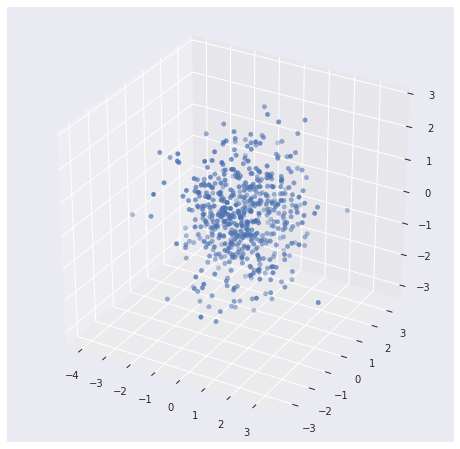

In [47]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(user_embeddings)
user_embeddings_pca = pca.transform(user_embeddings)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
xs, ys, zs = user_embeddings_pca[::150].T
ax.scatter(xs, ys, zs)

<pre>
# Copyright 2018 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
</pre>